## Лабораторная работа 3.
### Фильтрация изображений и морфологические операции

ФИО: Монастырный Максим Александрович

Группа: Б24-501 

In [1]:
from pathlib import Path

import numpy as np
from PIL import Image

In [2]:
data_dir = Path("../data")

Исходное изображение

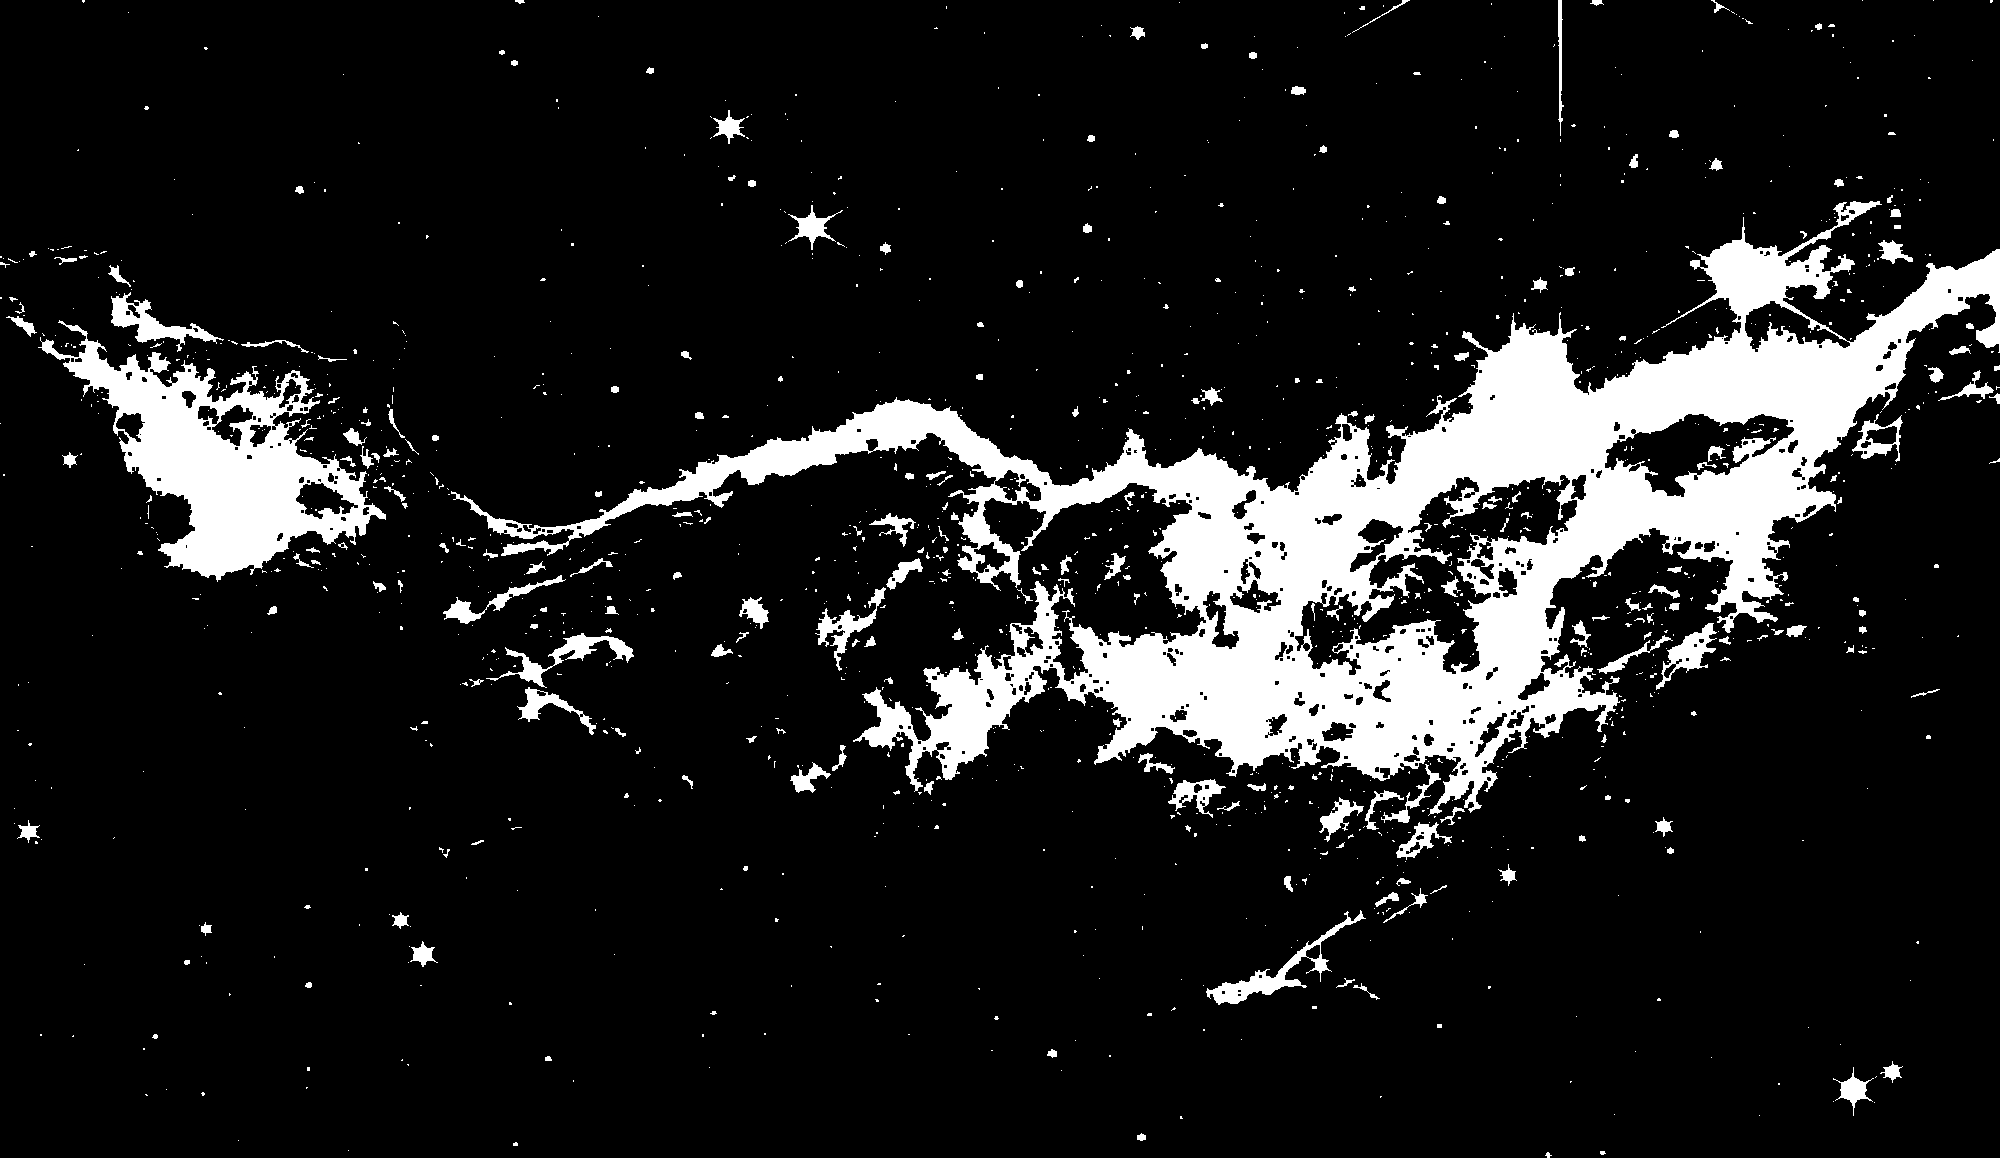

In [3]:
image_path = data_dir / "binarized_image.bmp"
raw_image = Image.open(image_path)
source_image = np.array(raw_image)
raw_image

Вариант 11:

Ранговый фильтр.
Окно 3x3.
Маска - холм.
Ранг 12/16.

In [4]:
def k_rank_filter(
    image: np.ndarray,
    mask: np.ndarray,
    k: int,
    padding_mode: str = "symmetric",
) -> np.ndarray:
    """Applies a weighted k-rank order filter to a grayscale image without loops.

    Each pixel in the local neighborhood is repeated according to its rounded
    mask weight. The k-th smallest value in this expanded multiset is selected.

    Args:
        image: 2D NumPy array of shape (H, W) with numeric dtype (grayscale).
        mask: 2D NumPy array of shape (M, N) with non-negative numeric values.
            M and N must be odd. Values are rounded to nearest integers to
            determine repetition counts.
        k: Rank order (1-based). Must satisfy 1 <= k <= sum(rounded_mask).
        padding_mode (str, optional): Padding mode for the image borders.
            Follows NumPy's `np.pad` modes (e.g., "symmetric", "reflect", "edge").
            Defaults to "symmetric".

    Returns:
        Filtered image with same shape and dtype as input.

    Raises:
        ValueError: If k is out of range, mask has even dimensions, or mask
                    contains negative values.
        TypeError: If inputs are not NumPy arrays or have invalid shapes.
    """
    if not isinstance(image, np.ndarray) or image.ndim != 2:
        raise TypeError("image must be a 2D NumPy array")
    if not isinstance(mask, np.ndarray) or mask.ndim != 2:
        raise TypeError("mask must be a 2D NumPy array")
    if not np.issubdtype(image.dtype, np.number):
        raise TypeError("image must have a numeric dtype")
    if not np.issubdtype(mask.dtype, np.number):
        raise TypeError("mask must have a numeric dtype")

    if k < 1:
        raise ValueError(f"k must be >= 1, got {k}")

    mh, mw = mask.shape
    if mh % 2 == 0 or mw % 2 == 0:
        raise ValueError(f"Mask dimensions must be odd, got ({mh}, {mw})")

    mask_int = np.round(mask).astype(int)
    if np.any(mask_int < 0):
        raise ValueError("Mask must have non-negative values")
    total_weight = int(np.sum(mask_int))
    if total_weight == 0:
        raise ValueError("Total mask weight is zero")
    if k > total_weight:
        raise ValueError(f"k ({k}) > total mask weight ({total_weight})")

    height, width = image.shape
    pad_height, pad_width = mh // 2, mw // 2

    padded = np.pad(
        image,
        ((pad_height, pad_height), (pad_width, pad_width)),
        mode=padding_mode,
    )

    windows = np.lib.stride_tricks.sliding_window_view(
        padded,
        window_shape=(mh, mw),
    )

    mask_repeated = np.tile(
        mask[np.newaxis, np.newaxis, :, :],
        (height, width, 1, 1),
    )
    masked = (windows * mask_repeated).sum(axis=(-2, -1))
    output_image = np.where(masked >= k * 255, 255, 0).astype(np.uint8)
    return output_image

In [5]:
mask = np.array(
    [
        [1, 2, 1],
        [2, 4, 2],
        [1, 2, 1],
    ],
    dtype=float,
)
k = 12

In [6]:
filtered_image = Image.fromarray(
    k_rank_filter(
        source_image,
        mask,
        k,
    )
)

In [7]:
filtered_image.save(data_dir / "filtered_image.bmp")

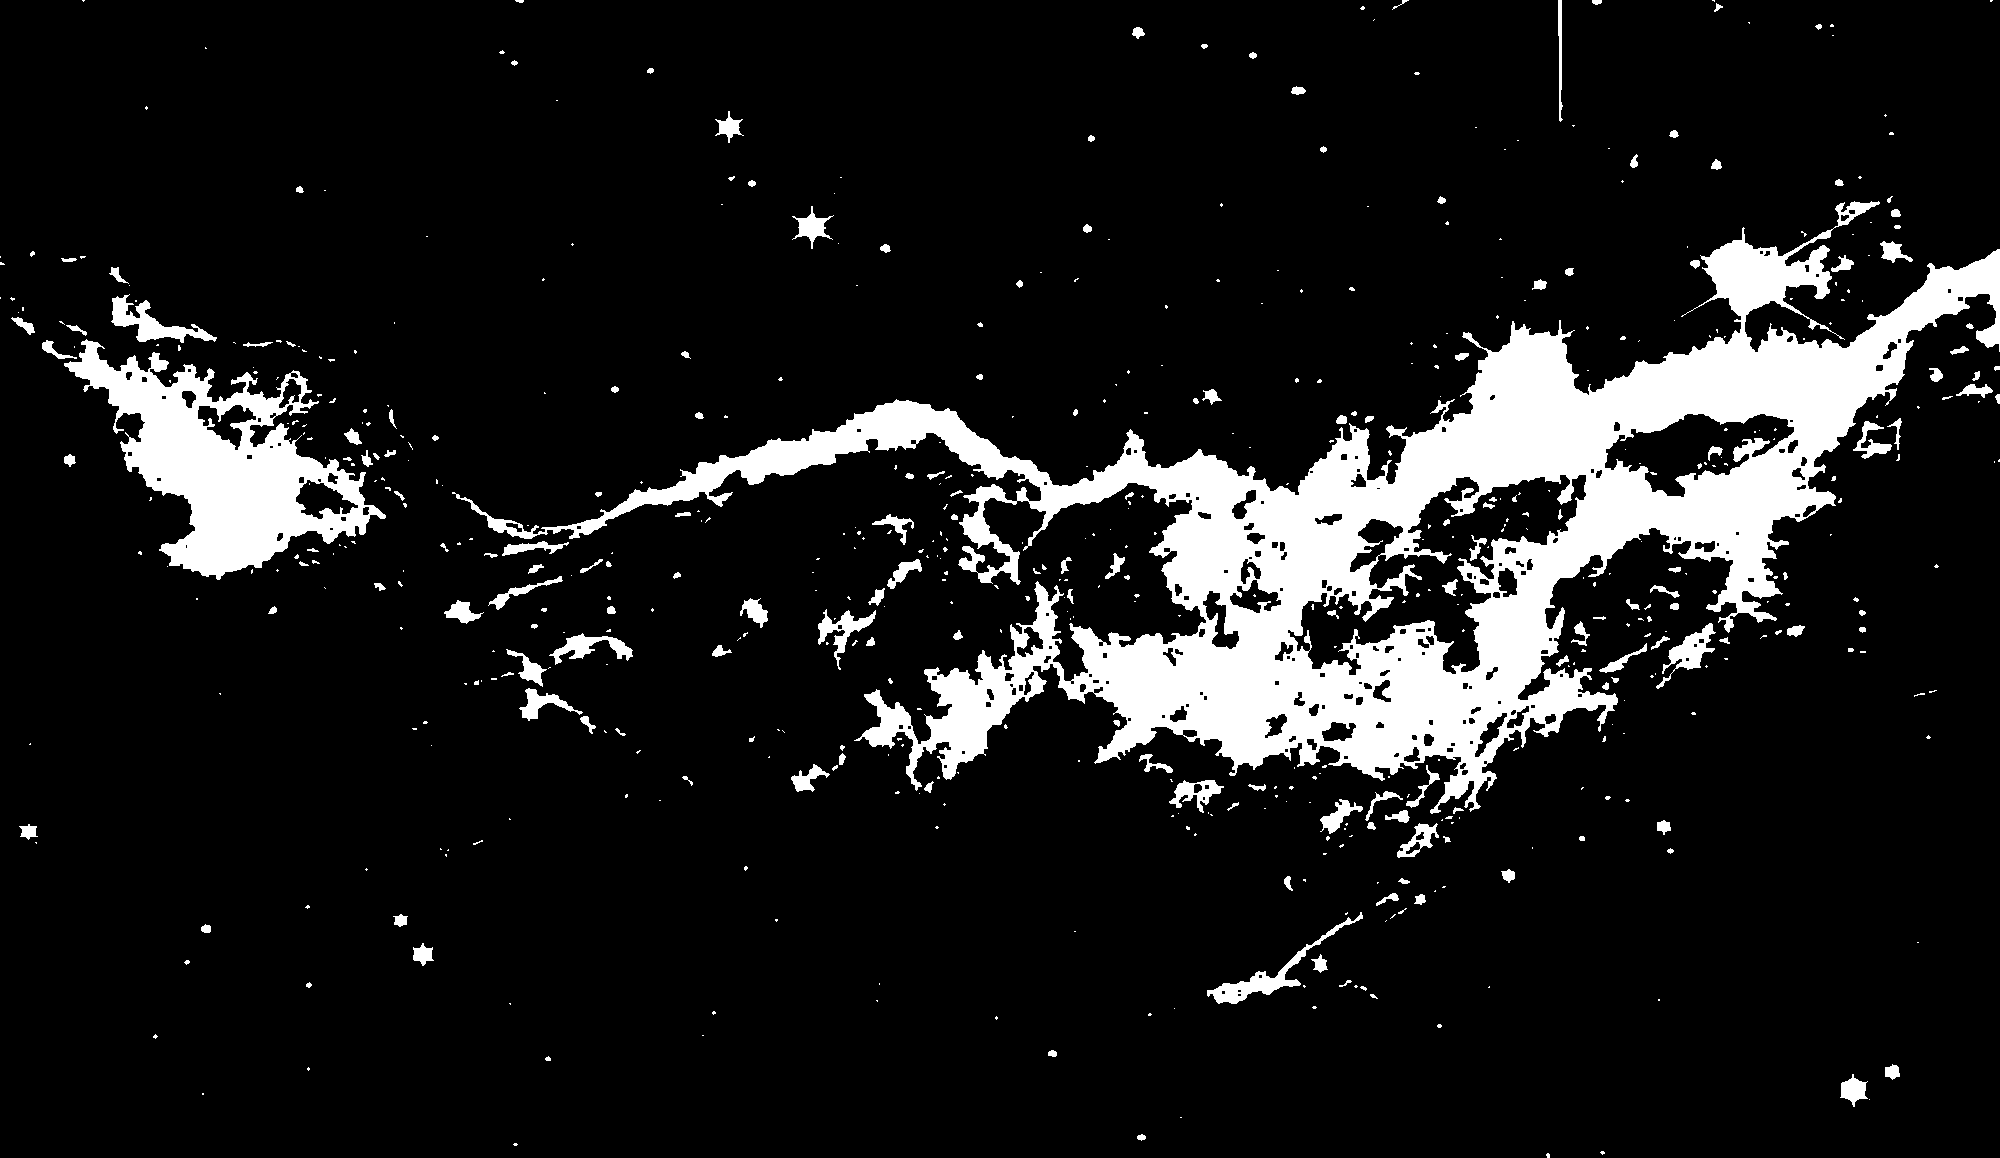

In [8]:
Image.open(data_dir / "filtered_image.bmp")

In [9]:
residual_image = Image.fromarray(np.array(source_image) - np.array(filtered_image))

In [10]:
residual_image.save(data_dir / "residual_image.bmp")

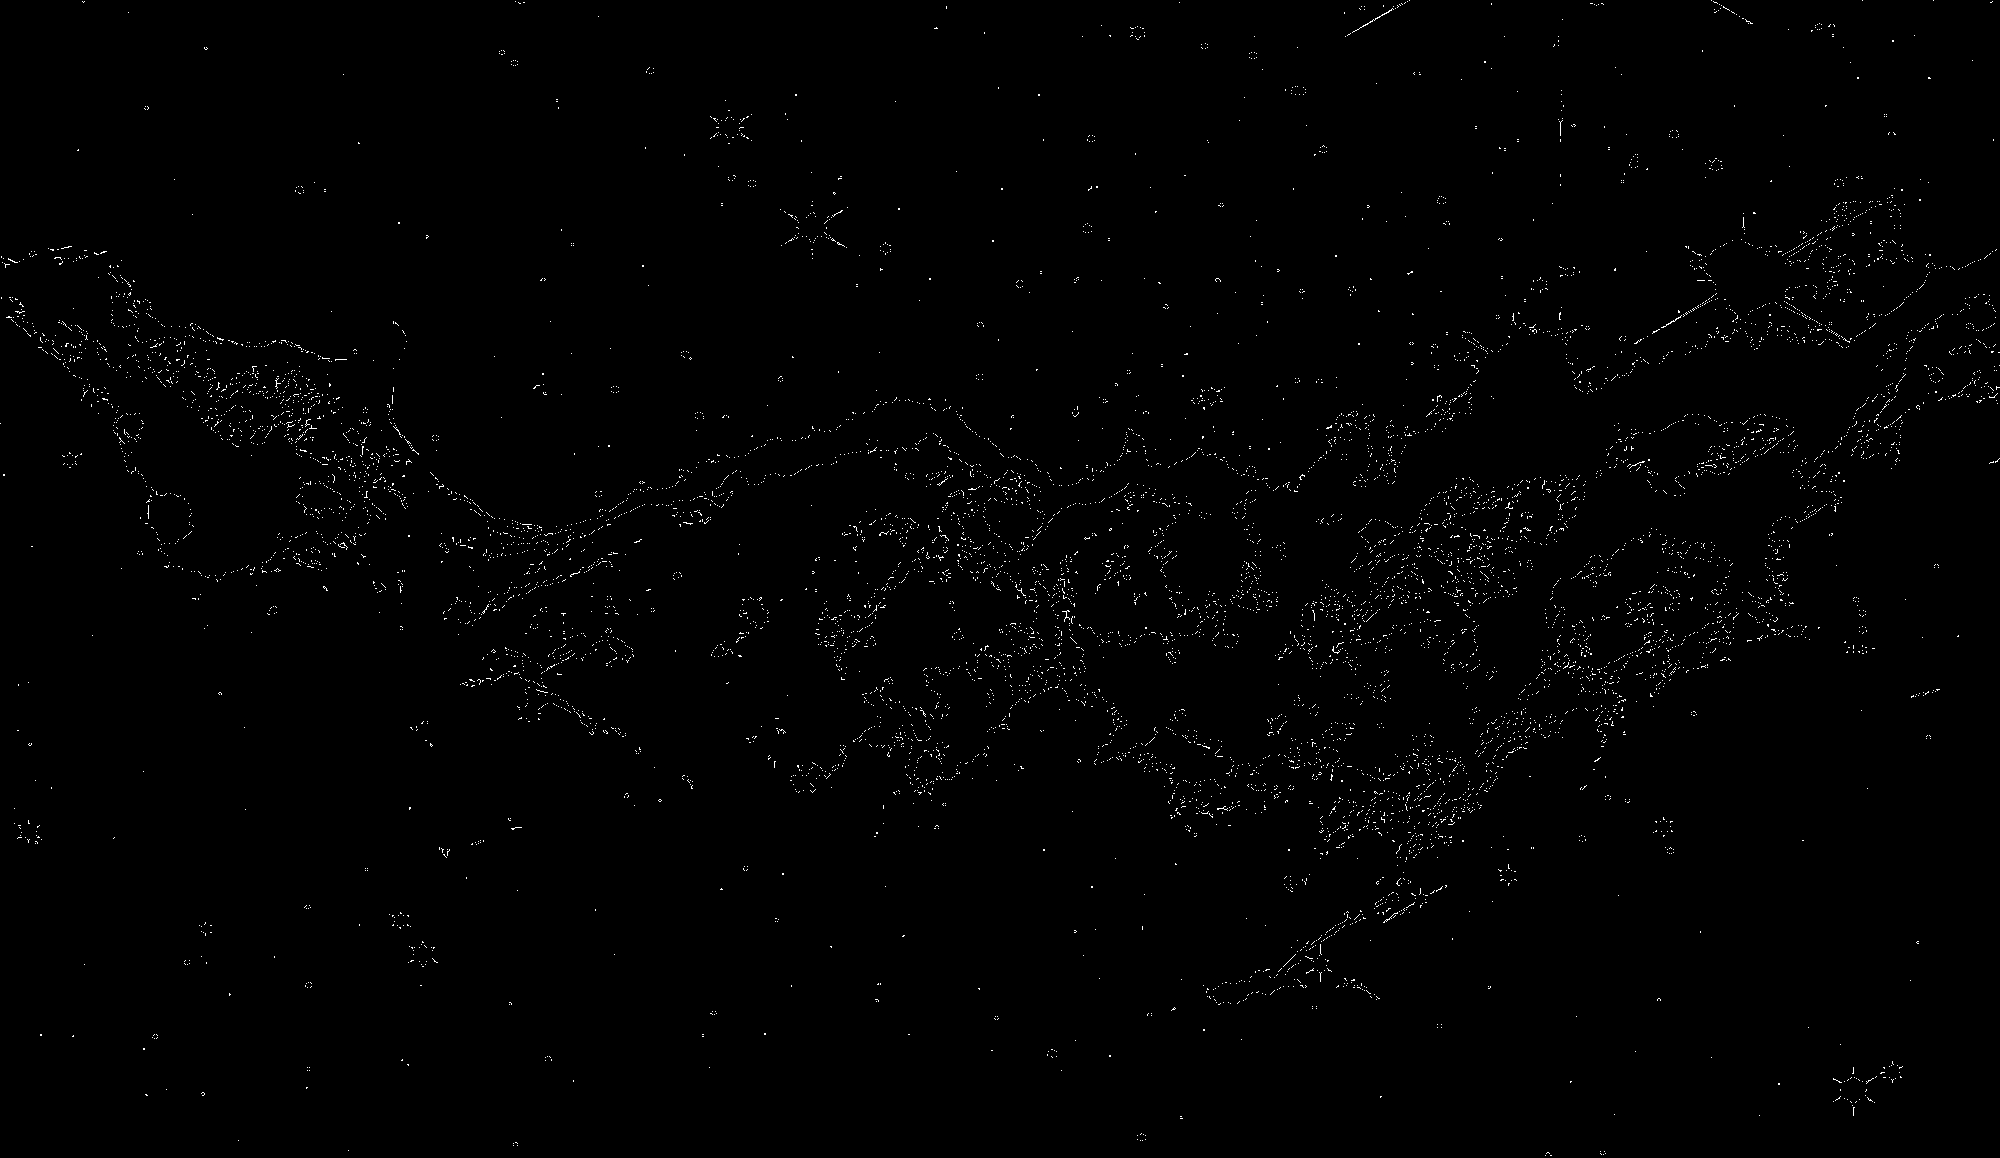

In [11]:
Image.open(data_dir / "residual_image.bmp")